# Import packages

In [1]:
from array import array
import itertools
import time
import math

import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex

Welcome to ROOTaaS 6.06/06


# File

In [2]:
#RootFile = 'InputData/13e_4L_SE_GMB_Ratio.root'
#RootFile = 'InputData/13d_4L_0GeVTrack_paired_SE_Correlation_GMB_Ratio.root'

#RootFile = 'InputData/13def_SE_GMB_Ratio.root'
#RootFile = 'InputData/13def_4L_SE_Correlation_GMB_Ratio_15_20.root'

RootFile = 'InputData/18b10a_calo_pthat1to2_SE_Correlation.root'
#RootFile = 'InputData/18b10a_calo_pthat4_SE_Correlation.root'
#RootFile = 'InputData/18b10a_calo_pthat1to2_0GeVTrack_paired_0GeVTracks_Correlation_0_to_10.root'
#RootFile = 'InputData/18b10a_calo_pthat1to2_GMB_0GeVTracks.root'
#RootFile = 'InputData/18b10a_calo_pthat1to2_SE_Correlation_GMB_Ratio.root'

#RootFile = 'InputData/17q_GMB_Correlation_lzt_0GeVTracks.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_Correlation.root'
#RootFile = 'InputData/17q_0GeVTrack_paired_SE_Correlation_GMB_Ratio.root'

# Define Bins and Purity


In [3]:
#FIXME: Read from Corr_config.yaml
#zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
pTbins = [0,0,12, 15]
purity = [1, 1, 0.30]
#purity = [1, 1, 0.55]
#pTbins = [0,0,15,20]

# Prefix

In [4]:
#prefix = '13def'
prefix = '18b10a'
#prefix = '18b10a'
#prefix = '18b10a_15_20'
#prefix = '13def_15_20'
#prefix = 'p-Pb'
#prefix = 'P-bp'
#prefix = 'pp'
#prefix = 'pp_mix'
#prefix = 'pp_Same_Only'

## Plot Titles

In [5]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    #histo.SetTitle("#gamma - h : p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
    #               %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.SetTitle("#gamma - h: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"%(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    histo.GetYaxis().SetTitleOffset(1.35)
    ROOT.gStyle.SetOptStat("")
    ROOT.gStyle.SetPalette(ROOT.kViridis)
    histo.SetMarkerStyle(20)
    histo.SetMarkerSize(2)
    histo.SetLineColor(4)
    histo.SetMarkerColor(4)
    if not(DNN_Bool):
        histo.SetLineColor(2)
        histo.SetMarkerColor(2)

# Label

In [6]:
def DrawLabel2(Signal_DNN = True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    if (Signal_DNN == "inclusive"):
        #latex.SetTextSize(0.04)
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.42,0.84, "#color[1]{p-Pb + Pb-p Inclusive}")
        else:
            latex.DrawLatex(0.42,0.84, "#color[1]{%s Inclusive}"%(prefix))
            
    elif (Signal_DNN):
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.42,0.84, "#color[4]{p-Pb + Pb-p Signal}")
        else:
            latex.DrawLatex(0.42,0.84, "#color[4]{%s Signal}"%(prefix))
            
    else:
        if (prefix=="13def" or prefix =="13def_15_20"):
            latex.DrawLatex(0.42,0.84, "#color[2]{p-Pb + Pb-p Bkgnd}")
        else:
            latex.DrawLatex(0.42,0.84, "#color[2]{%s Bkgnd}"%(prefix))

<sup> **Note** Scaling is done cell by cell (despite Axis title here) for accurate subtraction<sup>

# ZYAM

In [7]:
def Subtract_ZYAM (PhiProjection):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)
    

    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

In [8]:
def ZYAM_Line(hsig):
    Z_min = (hsig.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (hsig.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam_value = hsig.Integral(Z_min,Z_max)/(Z_N)
    #print Z_min, Z_max, Z_N
    ZYAM = ROOT.TLine(0,zyam_value,math.pi,zyam_value)
    ZYAM.SetLineColorAlpha(7, 0.9)
    ZYAM.SetLineWidth(5)
    SetOwnership(ZYAM, 0)
    return ZYAM

## N Triggers

In [9]:
def Get_NTriggers(filename,prfx,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (prfx =="18b10a"):
            NTriggers = ntrig_histo.Integral(0,-1)
        else:
            NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

## Large $\eta$

In [10]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True):
    file = ROOT.TFile(filename)

    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        LE_PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
        PhiProjection_pos = histo2D.ProjectionX('PosEta_inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                    100*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))
  
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
    
        #Project
        Eta_Axis = histo2D.GetYaxis()
    
        LE_PhiProjection = histo2D.ProjectionX('NegEta_DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
    
        PhiProjection_pos = histo2D.ProjectionX('PosEta_DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))    
    
    
    #Add,scale 
    LE_PhiProjection.SetDirectory(0)
    LE_PhiProjection.Add(PhiProjection_pos,1)
    #LE_PhiProjection.Rebin(2)
    LE_PhiProjection.Scale(1.0/1.2) #scale by eta region
    Plot1D(LE_PhiProjection,ipt,izt,Signal_DNN)
    LE_PhiProjection.SetMarkerStyle(25)
    LE_PhiProjection.SetLineColor(1)
    LE_PhiProjection.SetMarkerSize(2)
    LE_PhiProjection.SetMarkerColor(1)

    ntriggers = Get_NTriggers(filename,prefix, ipt, Signal_DNN)  
    if not(ntriggers == None):
        LE_PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
    #Legend
    #legend = ROOT.TLegend(0.64,0.78,0.89,0.88)
    legend = ROOT.TLegend(0.14,0.76,0.38,0.88)
    LE_PhiProjection.SetLineColorAlpha(1,0.9) #8 for light green
    #legend.AddEntry(LE_PhiProjection, "0.8 <|#eta| < 1.4","p")
    SetOwnership(legend, 0)
    file.Close()
    return LE_PhiProjection,legend

#### Simplify above with calls to getPhiProjection()

In [11]:
def GetLE_Line(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)+1) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4)-1)
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Line = ROOT.TLine(0,LE_value,math.pi,LE_value)
    LE_Line.SetLineColorAlpha(1, 0.9)
    LE_Line.SetLineWidth(5)
    SetOwnership(LE_Line, 0)
    #legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    legend.AddEntry(LE_Line, "0.8 <|#eta| < 1.4","l")
    SetOwnership(legend, 0)
    return LE_Line,legend

In [12]:
def Subtract_LE(PhiProjection,LE_Proj):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)+1) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4)-1)
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

#### Check

In [13]:
#LE,legend = GetLEProj(RootFile, 0, 0, True)
#cav = ROOT.TCanvas("cav","cav", 500,160)
#LE.Draw()
#legend.Draw()
#cav.Draw()
#GetLE_Line(LE)

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [14]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True, doZYAM=True):
    file = ROOT.TFile(filename)

    if (Signal_DNN == "inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                        #10*zTbins[izt+1]),5,11)
    
    PhiProjection.SetDirectory(0)
    #PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename,prefix,ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        Subtract_LE(PhiProjection,LE_Proj)
        #Subtract_ZYAM(PhiProjection)
    
    file.Close()
    return PhiProjection

In [15]:
GetPhiProj(RootFile,2,0,True,False)

<ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_5_8") at 0x65814b0>

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

### Side By Side

In [16]:
def SideSide(Region):
        Uncorr = False
        DoSub = False
        ptbin = 0
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        
        if (Region=="regions"):
            canvases.Divide(4,3)
            #canvases.Divide(3,2)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(6):
                
            if (Region=="regions"):              
            #grab
                hsig = GetPhiProj(RootFile,ptbin,ztbin,True,DoSub) #[DNN],[Subtraction Bool]
                hbkg = GetPhiProj(RootFile,ptbin,ztbin,False,DoSub)
                ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
                if not(DoSub):
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    hbkg.GetYaxis().SetRangeUser(0,ymax)  
                if (DoSub):
                    ymin = 1.4*min(hsig.GetMinimum(),hbkg.GetMinimum())
                    hsig.GetYaxis().SetRangeUser(ymin,ymax)
                    hbkg.GetYaxis().SetRangeUser(ymin,ymax)    
                
                canvases.cd(ztbin*2+1)
                #canvases.cd(ztbin+1)
                Sig_ZYAM= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                hsig.Draw()  
                DrawLabel2(True)
                if(Uncorr):
                    Sig_ZYAM.Draw("same")
                    LE_Line.Draw("same")
                    hsig.Draw("same")
                    LE_sig.Draw("same")
                    legend.AddEntry(Sig_ZYAM, "ZYAM","l")
                    legend.AddEntry(hsig,"High DNN","p")
                    legend.AddEntry(LE_sig, "0.8 <|#eta| < 1.4","p")
                    legend.Draw("same")

            if (Region=="inclusive"):
                    hsig = GetPhiProj(RootFile,ptbin,ztbin,"inclusive",False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    hsig.Draw()  
                    DrawLabel2("inclusive")
                    
                
            #Background
            if (Region=="regions"): 
                canvases.cd(ztbin*2+2)
                BKG_ZYAM = ZYAM_Line(hbkg)
                LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
                LE_bkg_Line,temp = GetLE_Line(LE_bkg)
                hbkg.Draw()
                DrawLabel2(False)
                if (Uncorr):
                    BKG_ZYAM.Draw("same")
                    LE_bkg_Line.Draw("same")
                    hbkg.Draw("same")
                    LE_bkg.Draw("same")
                    legend.AddEntry(BKG_ZYAM, "ZYAM","l")
                    legend.AddEntry(hbkg,"Low DNN","p")
                    legend.AddEntry(LE_bkg, "0.8 <|#eta| < 1.4","p")
                    legend.AddEntry(LE_bkg_Line, "0.8 > |#Delta#eta| > 1.4","l")
                    legend.Draw("same")
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/%s_Phi_2DNN_onlyZYAM.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN_onlyZYAM.png"%(prefix))
            else:
                canvases.SaveAs("pics/%s_Phi_2DNN.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN.png"%(prefix))
        return canvases
#myText(.2,.2,"hello_%i"%number,1)

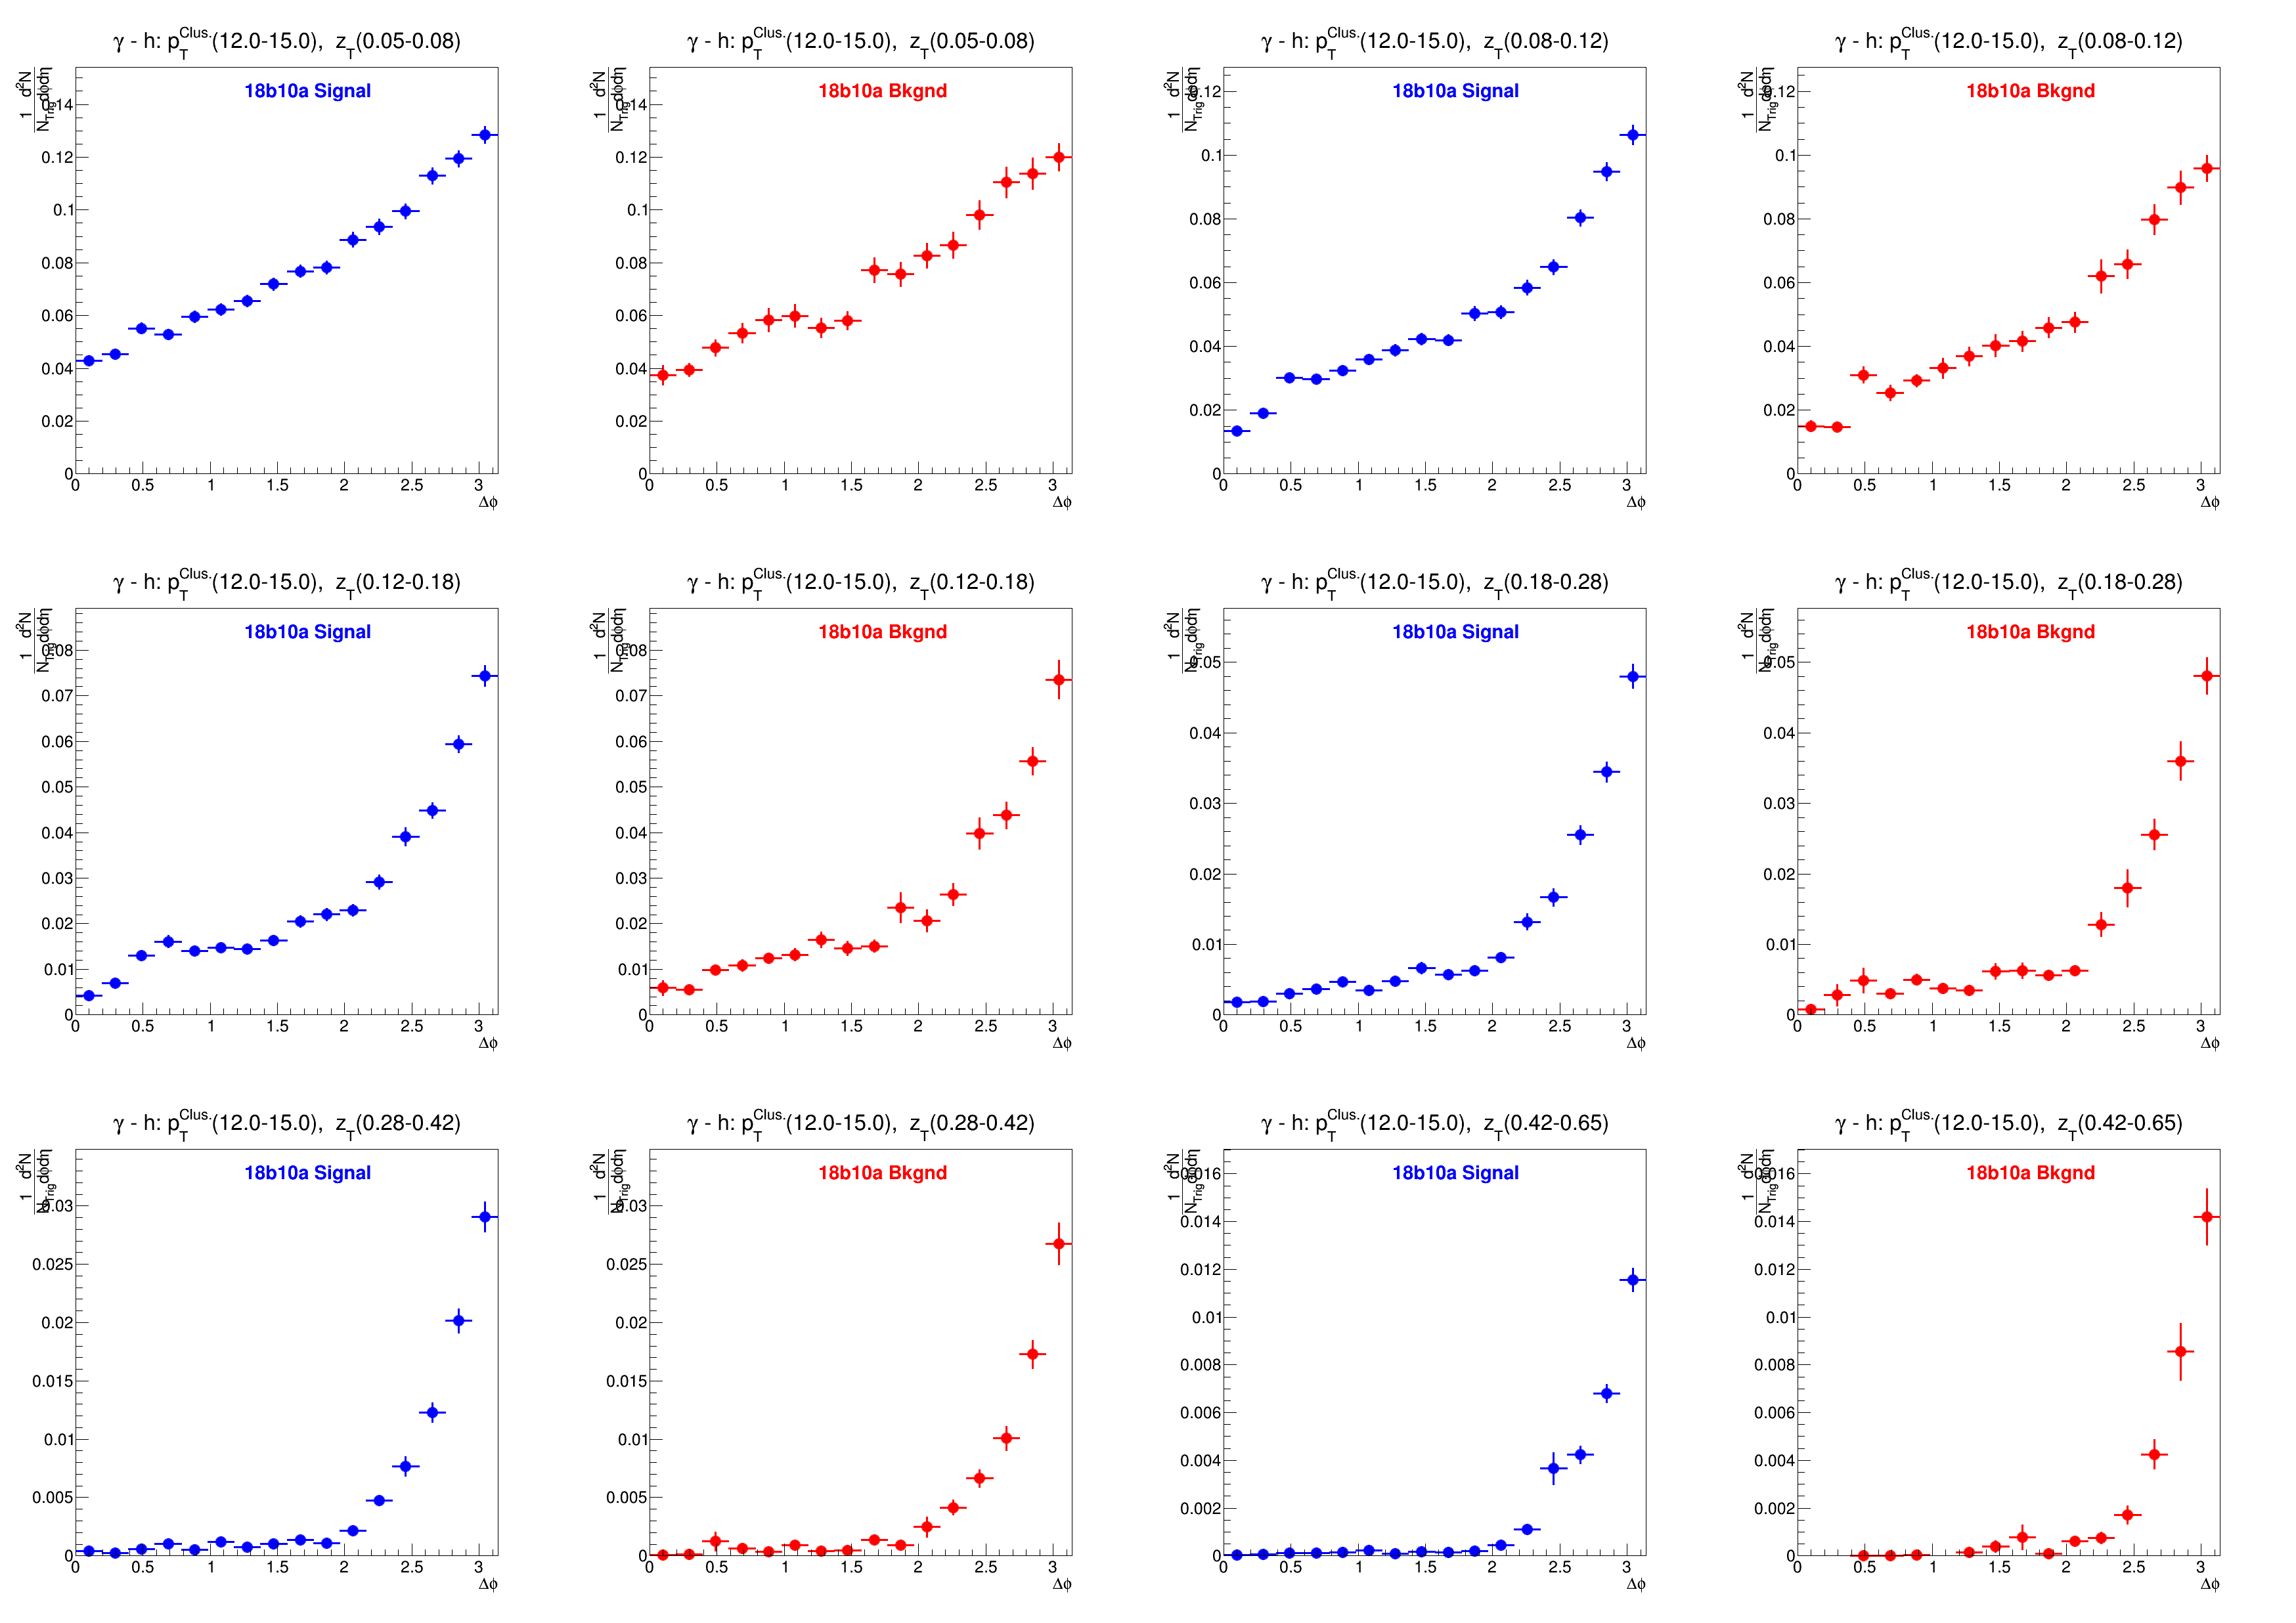

<ROOT.TCanvas object ("Canv_Side_Side_2") at 0x66b0d10>

Info in <TCanvas::Print>: pdf file pics/18b10a_Phi_2DNN.pdf has been created
Info in <TCanvas::Print>: png file pics/18b10a_Phi_2DNN.png has been created


In [17]:
SideSide("regions")
#SideSide("inclusive")

# Purity Scaling + Subtraction

#### Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [18]:
def GetBKGsubtracted(filename, ptbin, ztbin, doZYAM=True, doSubtraction=True):
    Signal = GetPhiProj(filename,ptbin,ztbin,True,doZYAM) #High DNN (True)
    Background = GetPhiProj(filename,ptbin,ztbin,False,doZYAM) #Low DNN (False)
    N1 = Get_NTriggers(filename,prefix,ptbin, True)
    N2 = Get_NTriggers(filename,prefix,ptbin, False)
    Background.Scale((1-purity[ptbin]))
   
    if (doSubtraction):
        Signal.Add(Background,-1)
        #Root handles errors correctly. Have checked with manual quadrature sum
    
    #Division by NTriggers done at phi projection function
    Signal.Scale(1.0/purity[ptbin])
    Background.Scale(1.0/purity[ptbin])
    
    Signal.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    Background.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    return Signal,Background,N1

In [19]:
def DrawLabel(NTriggers,ptbin):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    latex.DrawLatex(0.6,0.81, "#color[2]{purity = %1.2f}"%(purity[ptbin]))
    #latex.DrawLatex(0.12,0.85, "#color[2]{no purity scaling}")
    latex.DrawLatex(0.12,0.81, "#color[4]{%1.0f Triggers}"%(NTriggers))

In [20]:
def DrawLabel3(NTriggers,DoSub=True):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    if (DoSub):
        latex.SetTextSize(0.04)
        #latex.DrawLatex(0.12,0.85, "#color[4]{%1.0f Triggers}"%(NTriggers))
        if (prefix=="13def"):
            latex.DrawLatex(0.12,0.85, "#color[4]{pPb+Pbp After Subtraction}")
        else:
            latex.DrawLatex(0.12,0.85, "#color[4]{%s After Subtraction}"%(prefix))
    else: 
        if (prefix=="13def"):
            latex.DrawLatex(0.12,0.85, "#color[4]{p-Pb + Pb-p Signal}")
            latex.DrawLatex(0.6,0.85, "#color[2]{(1-p)Bkgnd}")
        else:
            latex.DrawLatex(0.12,0.85, "#color[4]{%s Signal}"%(prefix))
            latex.DrawLatex(0.6,0.85, "#color[2]{%s (1-p)Bkgnd}"%(prefix))

# Loop and Plot

In [21]:
def Looping(filename,DoZYAM,DoSub=True):
    canvases = []
    subtracts = []
    newfile = ROOT.TFile("%s_subtracted_correlation.root"%(prefix),"RECREATE")
    ROOT.gDirectory.pwd()
    
    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",3000,2000))
        canvases[ptbin].Divide(3,2)
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        for ztbin in range(6):
            hsig,hbkg,NTrig = GetBKGsubtracted(filename,ptbin,ztbin,DoZYAM,DoSub)#doZYAM,doSubtraction
            canvases[ptbin-2].cd(ztbin+1)            
            
            ymax = 0.8*max(hsig.GetMaximum(),hbkg.GetMaximum())
            ymin = -2*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
            hsig.GetYaxis().SetRangeUser(ymin,ymax)
            hbkg.GetYaxis().SetRangeUser(ymin,ymax)            
            hsig.Draw()

            #Overlay
            if not(DoSub):
                DrawLabel(NTrig,ptbin)
                hbkg.Draw("same")
                canvases[ptbin-2].Update()
                legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
                legend.AddEntry(hsig, "0.55 < DNN < 0.85","p")
                legend.AddEntry(hbkg, "0.0 < DNN < 0.3","p")
                #SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
                #legend.Draw("same")
                DrawLabel3(NTrig,DoSub)
                
                #show unscaled
                #Bkgd = GetPhiProj(filename,ptbin,ztbin,False,DoZYAM)
                #Bkgd.SetMarkerStyle(21)
                #Bkgd.Draw("same")
        
            else:     
                #draw line at 0
                zero_line = ROOT.TLine(0,0,math.pi,0)
                zero_line.SetLineColorAlpha(2, 0.9)
                zero_line.SetLineWidth(2)
                SetOwnership(zero_line, 0)
                zero_line.Draw("same")
                DrawLabel3(NTrig,DoSub)
                #ROOT.gDirectory = newfile.GetDirectory()
                #hsig.SetDirectory(newfile)
                #hsig.GetCurrentFile().Write()
                ROOT.gFile = newfile
                ROOT.gDirectory = newfile
                ROOT.gDirectory.pwd()
                newfile.cd()
                hsig.Write()

            #TPave
            
        canvases[ptbin-2].Draw()
  
        if (DoSub): 
            canvases[ptbin-2].SaveAs('pics/%s_Subtracted.pdf'%(prefix))
            canvases[ptbin-2].SaveAs('pics/%s_Subtracted.png'%(prefix))
        else: 
            canvases[ptbin-2].SaveAs('pics/%s_correlations_Overlay.pdf'%(prefix))
            canvases[ptbin-2].SaveAs('pics/%s_correlations_Overlay.png'%(prefix))
    newfile.Close()
    return canvases

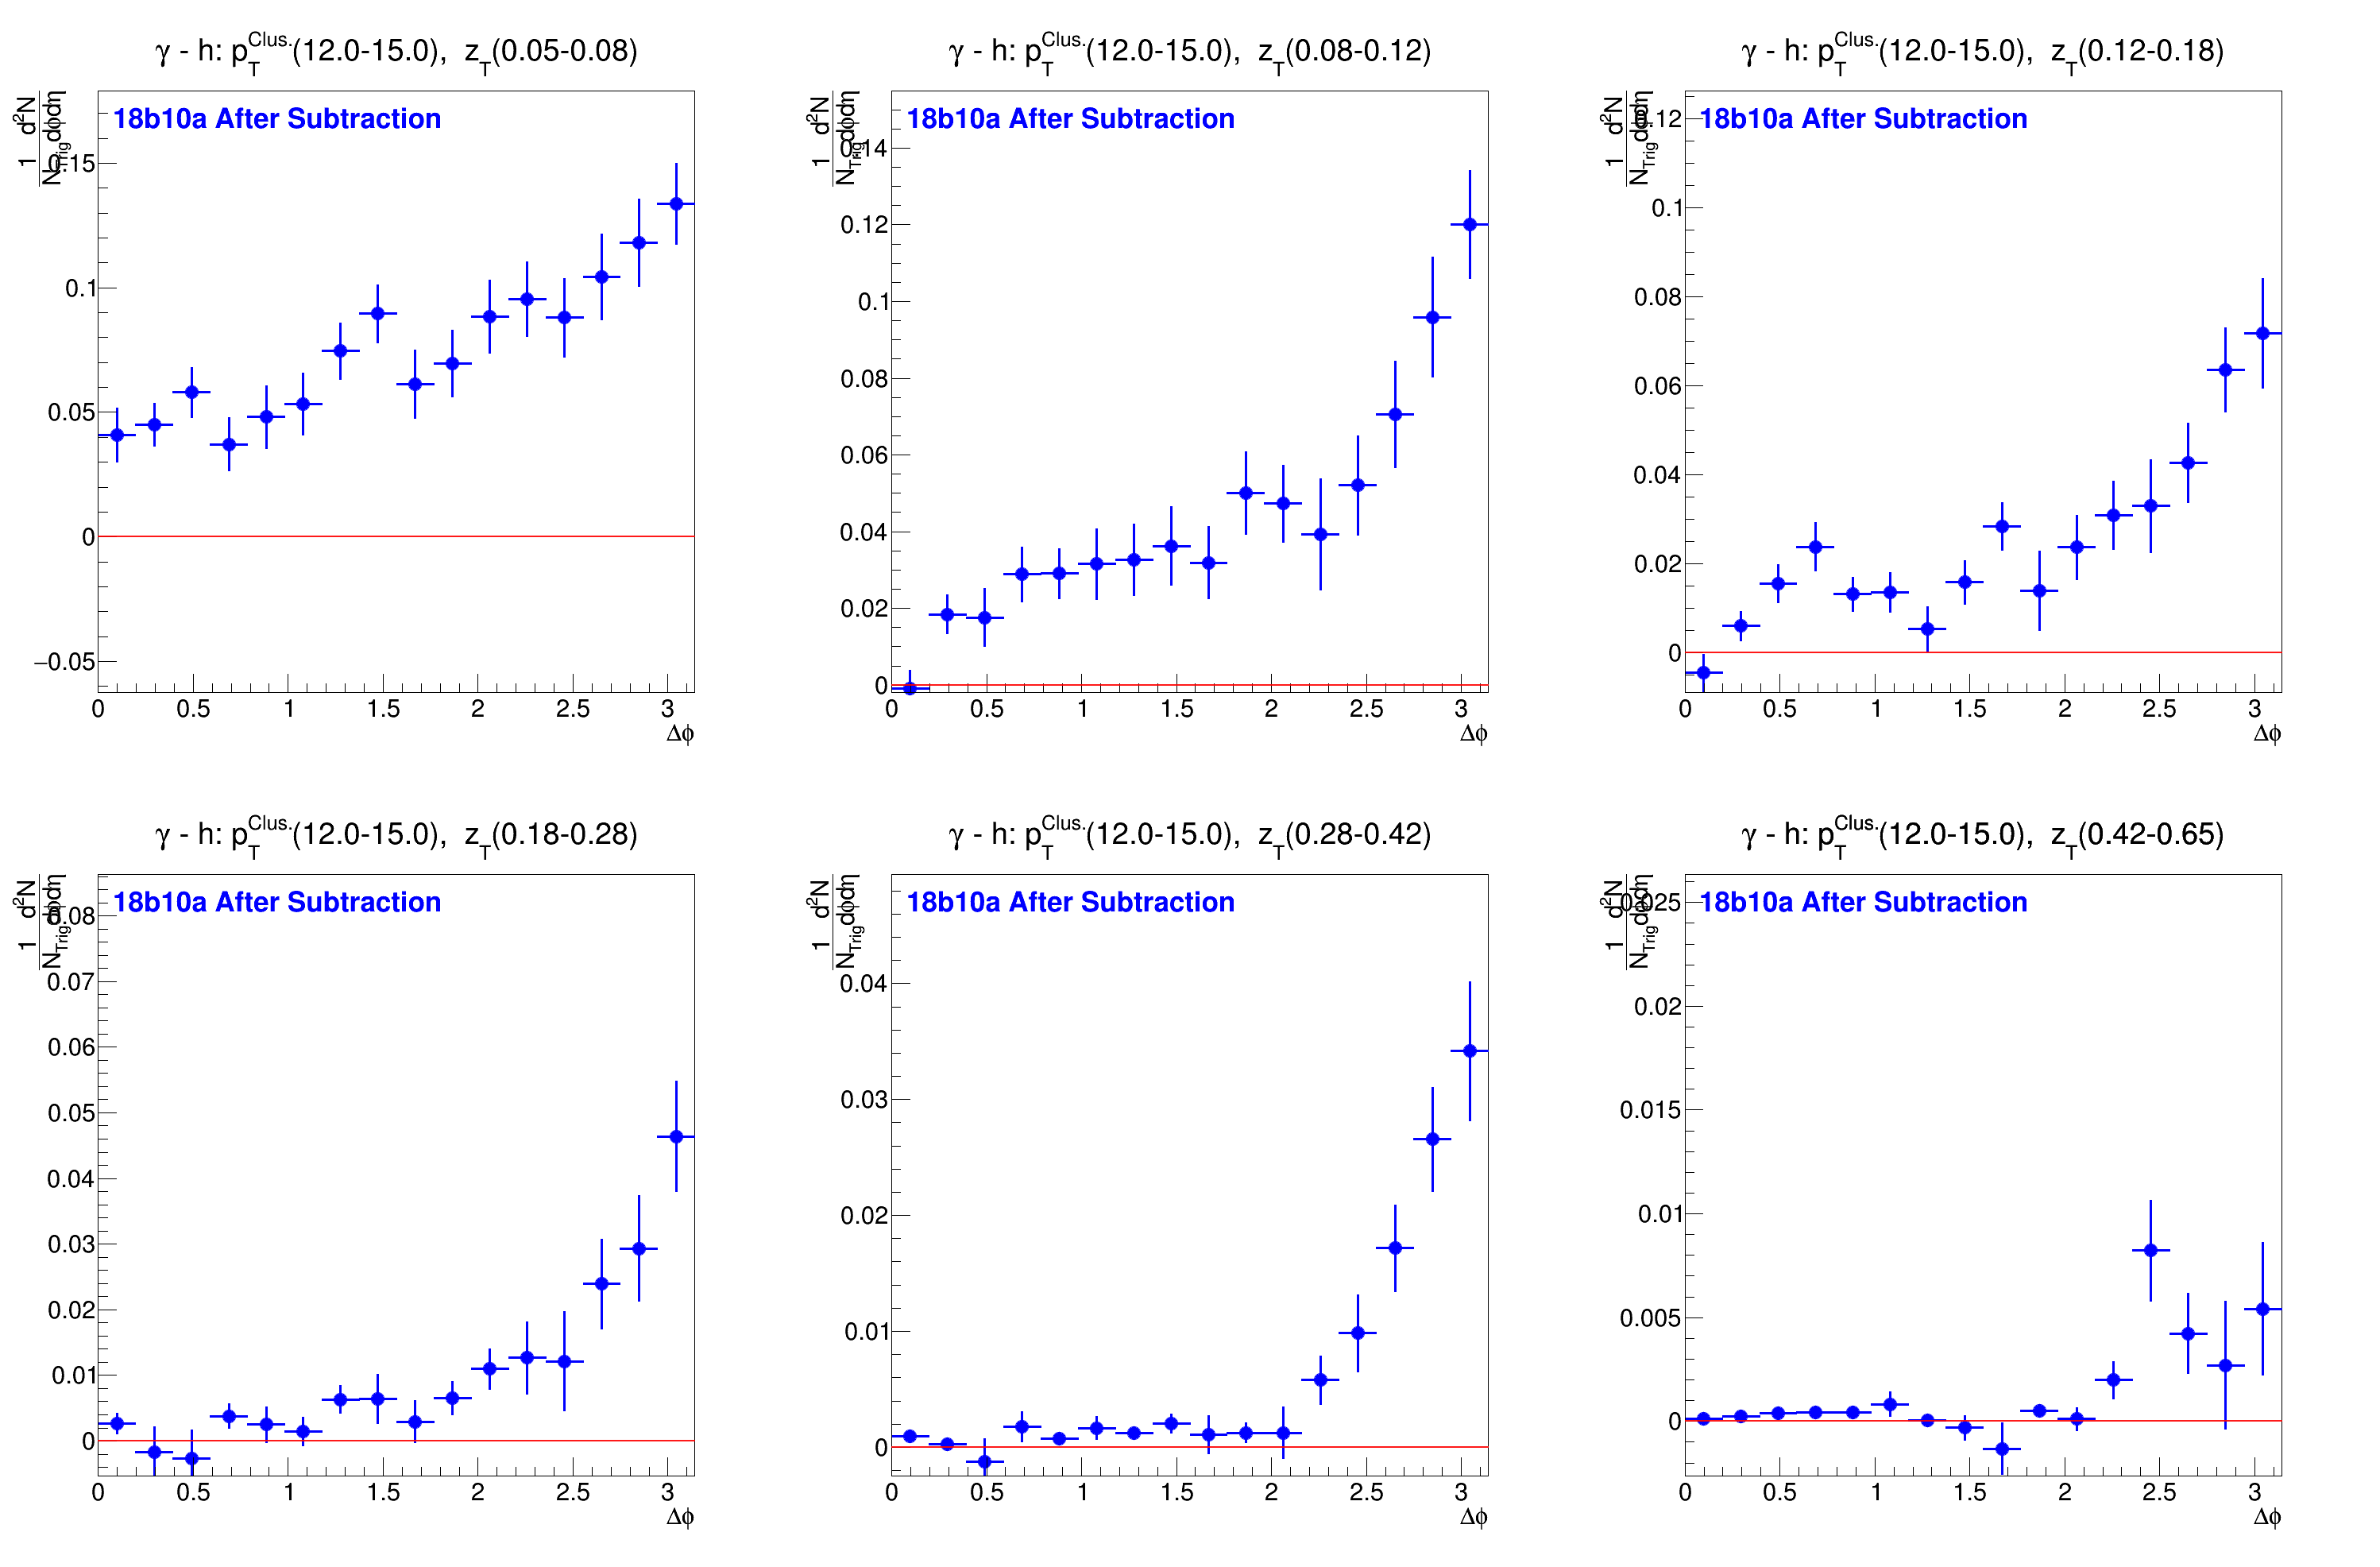

[<ROOT.TCanvas object ("canv0") at 0x6a62d90>,
 <ROOT.TCanvas object ("canv1") at 0x6b7cb70>,
 <ROOT.TCanvas object ("canv2") at 0x6b6dac0>]

18b10a_subtracted_correlation.root:/
18b10a_subtracted_correlation.root:/
18b10a_subtracted_correlation.root:/
18b10a_subtracted_correlation.root:/
18b10a_subtracted_correlation.root:/
18b10a_subtracted_correlation.root:/
18b10a_subtracted_correlation.root:/


Info in <TCanvas::Print>: pdf file pics/18b10a_Subtracted.pdf has been created
Info in <TCanvas::Print>: png file pics/18b10a_Subtracted.png has been created


In [22]:
Looping(RootFile,True,True)#Filename,DoZYAM,DoSub

# Fragmentation Function

In [23]:
def FF(filename):
    zT_integral = []
    zT_point = []
    zT_error = []
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        
        for ztbin in range(6):
            hsig,hbkg,NTrig = GetBKGsubtracted(filename,ptbin,ztbin,True,True)#doZYAM,doSubtraction 
            Phi_bin_min = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi)-1    
            #zT_point.append((zTbins[ztbin] + zTbins[ztbin+1])/2)
            zT_point.append(zTbins[ztbin])
            zT_integral.append(hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi)))
            
            #errors
            zt_tmp_e = 0.0
            for phibin in range(Phi_bin_min, Phi_bin_max+1):
                #print "Relative Error: ",hsig.GetBinError(phibin)/(hsig.GetBinContent(phibin))," Bin Content ", hsig.GetBinContent(phibin), " Absolute Error: ", hsig.GetBinError(phibin)
                
                zt_tmp_e += (hsig.GetBinError(phibin))**2
                #print math.sqrt(zt_tmp_e)
            print "Quadrature sum, relative Error", (math.sqrt(zt_tmp_e)/zT_integral[ztbin])
            #print " "
            zT_error.append(math.sqrt(zt_tmp_e))
            
    #print zT_error
    plt.plot(zT_point,zT_integral,'bo')
    plt.errorbar(zT_point, zT_integral, yerr=zT_error, fmt='s')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('%s: Integrated $\gamma$-Hadron $2\pi/3 < \Delta\phi < \pi$ '%(prefix))
    plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w')
    #figure.show()
    plt.show()
    plt.figure(num=None, figsize=(12, 8), dpi=100, facecolor='w').savefig("pics/%s_FFunction.pdf"%(prefix), bbox_inches='tight')

Quadrature sum, relative Error 0.0628765755373
Quadrature sum, relative Error 0.0785998044882
Quadrature sum, relative Error 0.0875871615157
Quadrature sum, relative Error 0.123113853056
Quadrature sum, relative Error 0.100291014636
Quadrature sum, relative Error 0.242887090866


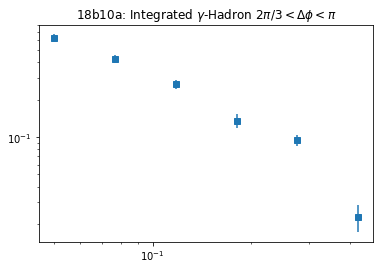

In [24]:
FF(RootFile)

In [25]:
#np.geomspace(0.05,1,8)

# Overlay MC and Data

In [26]:
#prefix ='13def'

In [27]:
def MC_DATA(Region):
        Uncorr = False
        DoSub = True
        ptbin = 0
        ptbin = ptbin+2;
        MC_Phis = []
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        
        if (Region=="regions"):
            #canvases.Divide(4,3)
            canvases.Divide(3,2)
        elif(Region=="inclusive"):
            canvases.Divide(3,2)
            
        for ztbin in range(6):
                
            if (Region=="regions"):              
            #grab
                
                prefix = '18b10a'
                prefix = '13def'
                hsig = GetPhiProj(RootFile,ptbin,ztbin,True,DoSub) #[DNN],[Subtraction Bool]
                MC_Phis.append(hsig)
                hbkg = GetPhiProj(RootFile,ptbin,ztbin,False,DoSub)
                ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
                if not(DoSub):
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    hbkg.GetYaxis().SetRangeUser(0,ymax)  
                if (DoSub):
                    ymin = 1.4*min(hsig.GetMinimum(),hbkg.GetMinimum())
                    hsig.GetYaxis().SetRangeUser(ymin,ymax)
                    hbkg.GetYaxis().SetRangeUser(ymin,ymax)    
                
                #canvases.cd(ztbin*2+1)
                canvases.cd(ztbin+1)
                Sig_ZYAM= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
                LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
                LE_Line,temp = GetLE_Line(LE_sig)
                hsig.Draw()  
                DrawLabel2(True)
                if(Uncorr):
                    Sig_ZYAM.Draw("same")
                    LE_Line.Draw("same")
                    hsig.Draw("same")
                    LE_sig.Draw("same")
                    legend.AddEntry(Sig_ZYAM, "ZYAM","l")
                    legend.AddEntry(hsig,"High DNN","p")
                    legend.AddEntry(LE_sig, "0.8 <|#eta| < 1.4","p")
                    legend.Draw("same")

            if (Region=="inclusive"):
                    hsig = GetPhiProj(RootFile,ptbin,ztbin,"inclusive",False)
                    ymax = 1.2*hsig.GetMaximum()
                    hsig.GetYaxis().SetRangeUser(0,ymax)
                    canvases.cd(ztbin+1) 
                    hsig.Draw()  
                    DrawLabel2("inclusive")
                    
                
            #Background
            if not(Region=="regions"): 
                canvases.cd(ztbin*2+2)
                BKG_ZYAM = ZYAM_Line(hbkg)
                LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
                LE_bkg_Line,temp = GetLE_Line(LE_bkg)
                hbkg.Draw()
                DrawLabel2(False)
                if (Uncorr):
                    BKG_ZYAM.Draw("same")
                    LE_bkg_Line.Draw("same")
                    hbkg.Draw("same")
                    LE_bkg.Draw("same")
                    legend.AddEntry(BKG_ZYAM, "ZYAM","l")
                    legend.AddEntry(hbkg,"Low DNN","p")
                    legend.AddEntry(LE_bkg, "0.8 <|#eta| < 1.4","p")
                    legend.AddEntry(LE_bkg_Line, "0.8 > |#Delta#eta| > 1.4","l")
                    legend.Draw("same")
        canvases.Update()
        canvases.Draw()
        if (Region=="inclusive"):
            canvases.SaveAs("pics/%s_Inclusive_Phi.pdf"%(prefix))
            canvases.SaveAs("pics/%s_Inclusive_Phi.png"%(prefix))
        if (Region=="regions"):
            if(Uncorr):
                canvases.SaveAs("pics/%s_Phi_2DNN_onlyZYAM.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN_onlyZYAM.png"%(prefix))
            else:
                canvases.SaveAs("pics/%s_Phi_2DNN.pdf"%(prefix))
                canvases.SaveAs("pics/%s_Phi_2DNN.png"%(prefix))
        return MC_Phis
#myText(.2,.2,"hello_%i"%number,1)

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: Canv_Side_Side_2


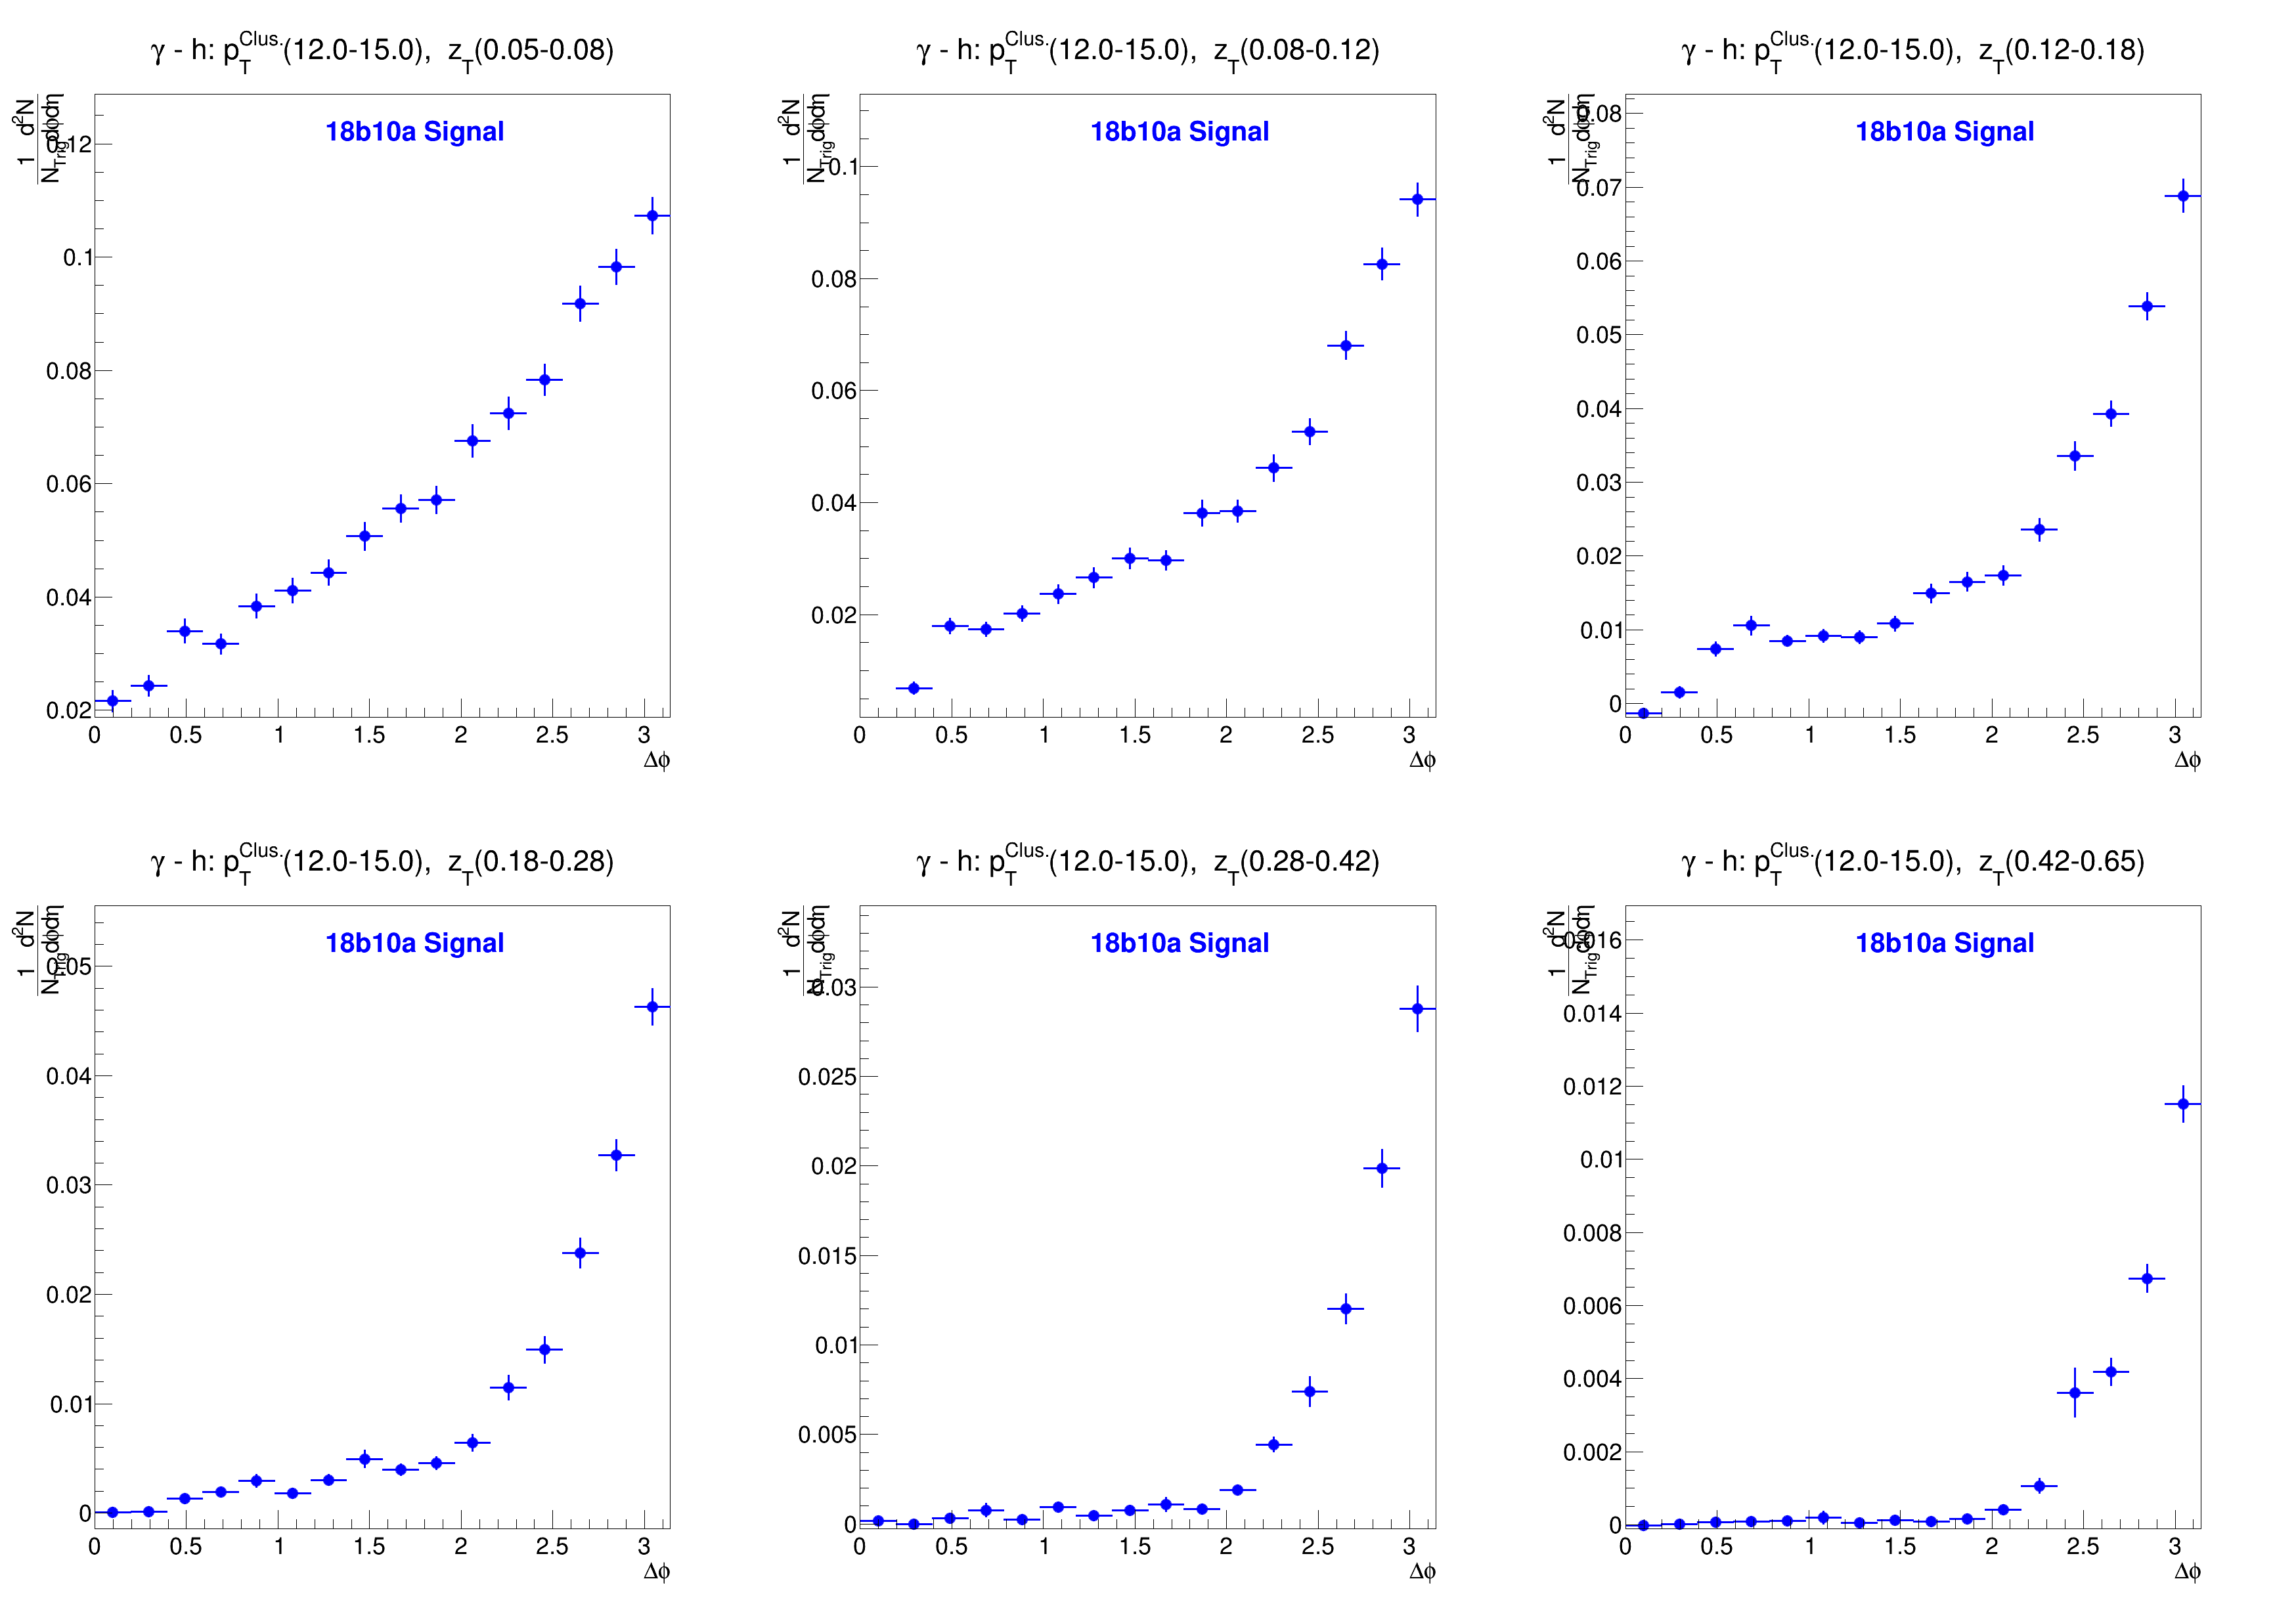

[<ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_5_8") at 0x774c590>, <ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_8_12") at 0x72b94d0>, <ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_12_18") at 0x6eb5170>, <ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_18_28") at 0x76b2ce0>, <ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_28_42") at 0x7737020>, <ROOT.TH1D object ("DNN1_PhiProjection__pT_12_15__zt_42_65") at 0x7739030>]


Info in <TCanvas::Print>: pdf file pics/13def_Phi_2DNN.pdf has been created
Info in <TCanvas::Print>: png file pics/13def_Phi_2DNN.png has been created


In [28]:
a = MC_DATA("regions")
print a